In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime
from collections import defaultdict
import bisect
from math import sqrt

In [2]:
path = 'Corr_data/'
os.listdir(path)

['inp_z_filter.csv',
 'imp.csv',
 'out_gk_filter.csv',
 'out_gk_filter_test.csv',
 'imp_pos.csv',
 'imp_force.csv',
 'inp_z_filter_test.csv']

In [3]:
z = pd.read_csv(path+'imp_pos.csv')
f = pd.read_csv(path+'imp_force.csv')
z.head()

,1,24,1.123,1.1417,0.1266,0.1107
0,1,32,2.3897,2.3153,0.1900,0.1593
1,1,36,3.1339,3.0440,0.1900,0.1752
2,1,41,4.1630,4.0745,0.2058,0.2057
3,1,46,5.1910,5.1539,0.2058,0.2215
4,1,50,5.9995,5.9949,0.2058,0.2069


In [4]:
print(f.head())
len(z),len(f)

   1  24  0.0687
0  1  32  0.2033
1  1  36  0.3056
2  1  41  0.4169
3  1  46  0.5356
4  1  50  0.6588


(3372, 3372)

In [5]:
X0 = pd.read_csv('Corr_data/inp_z_filter.csv', names = ['{}'.format(i) for i in range(5)])
X0_test = pd.read_csv('Corr_data/inp_z_filter_test.csv', names = ['{}'.format(i) for i in range(5)])
Y0 = pd.read_csv('Corr_data/out_gk_filter.csv', names = ['{}'.format(i) for i in range(2)])
Y0_test = pd.read_csv('Corr_data/out_gk_filter_test.csv', names = ['{}'.format(i) for i in range(2)])
X0.head()

,0,1,2,3,4
0,1,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000
2,1,-0.001160,0.000000,-0.001160,0.000000
3,1,-0.003311,0.001248,-0.002151,0.001248
4,1,-0.005148,0.003561,-0.001837,0.002313


In [6]:
Y0.head()

,0,1
0,1,-0.003641
1,1,-0.010413
2,1,-0.014985
3,1,-0.016695
4,1,-0.017878


In [7]:
print(len(Y0),len(Y0_test))

116448 58224


In [8]:
from scipy import *
from scipy.linalg import norm, pinv
import math
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

# y = Wx + P
class RBF:
     
    def __init__(self, indim, outdim, center_inds):
        self.indim = indim
        self.center_inds = center_inds
        self.outdim = outdim
        self.numCenters = len(self.center_inds)
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(self.numCenters)]
        self.W = np.random.random((self.numCenters, self.outdim))
        self.P = LinearRegression()
        self.lr = LinearRegression()
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**1.5
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        self.P.fit(X,Y)
        rnd_idx = self.center_inds
        self.centers = [X[i,:] for i in rnd_idx]
         
        # print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        # print(G) 
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
        val = np.zeros((len(X),2))
        val[:,0] = np.dot(G, self.W)
        val[:,1] = self.P.predict(X)
        # print(val.shape)
        self.lr.fit(val,Y)
        
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        Y2 = self.P.predict(X)
        val = np.zeros((len(X),2))
        val[:,0] = Y
        val[:,1] = Y2
        return self.lr.predict(val)

In [9]:
def FBL():
    x = np.array(z.iloc[:,2:])
    y = np.array(f.iloc[:,2])
    
    centers_ind = [1]
    to_return = [1]
    got = defaultdict(lambda : 1)
    got[1]=0
    if 1 == 1:
        rbf = RBF(4, 1,centers_ind)
        rbf.train(x, y)

        y1 = rbf.test(x)
        maxi,ind = 0,0
        for i in range(len(y)):
            if i not in centers_ind and norm(y[i]-y1[i])/(1+norm(y[i]))>maxi:
                maxi = norm(y[i]-y1[i])/(1+norm(y[i]))
                ind = i
        p = 0.6
        error = mean_squared_error(y,y1)**p
        
        while error>0.15 and len(centers_ind)<len(y)//5:
            centers_ind.append(ind)
            start = bisect.bisect_left(np.array(Y0.iloc[:,0]), f.iloc[ind,0])
            to_return.append(start+f.iloc[ind,1])
            
            for j in range(ind-3,ind+3):
                got[j]=0
            rbf = RBF(4, 1, centers_ind)
            rbf.train(x,y)

            y1 = rbf.test(x)

            maxi,ind = 0,0
            for i in range(len(y)):
                if got[i] and norm(y[i]-y1[i])/(1+norm(y[i]))>maxi:
                    maxi = norm(y[i]-y1[i])/(1+norm(y[i]))
                    ind = i
            
            error = mean_squared_error(y,y1)**p
            #print(error,ind,to_return[-1])
        #print(centers_ind)
        return to_return

In [10]:
t1 = datetime.now()

Final_indices = FBL()
t2 = datetime.now()

In [11]:
len(Final_indices)

116

In [12]:
class RBF1:
     
    def __init__(self, indim,outdim, centers_ind):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = len(centers_ind)
        self.centers_ind = centers_ind
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(self.numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = self.centers_ind
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [13]:
t2 = datetime.now()
x = np.array(X0.iloc[:,1:])
y = np.array(Y0.iloc[:,1])

rbf = RBF1(4, 1,Final_indices)
rbf.train(x, y)
t3 = datetime.now()

In [14]:
print('time taken by entire FBL:', t3-t1)
print('Important point calculation time:', t2-t1)

time taken by entire FBL: 0:21:48.994925
Important point calculation time: 0:17:03.802210


In [15]:
x_test = np.array(X0_test.iloc[:,1:])
y_test = np.array(Y0_test.iloc[:,1])
y1 = rbf.test(x_test)
print('Root Mean Squared error: ', mean_squared_error(y_test,y1)**0.5)

Root Mean Squared error:  0.06963273600728259


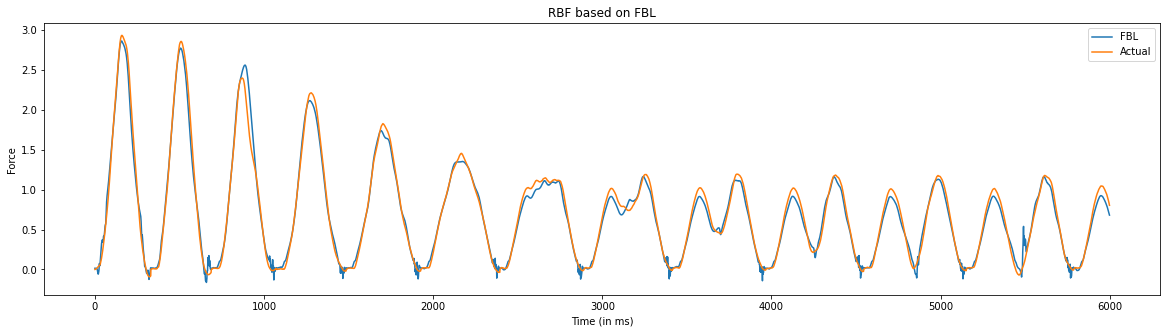

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(list(range(6000)),y1[:6000], label = 'FBL')
plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

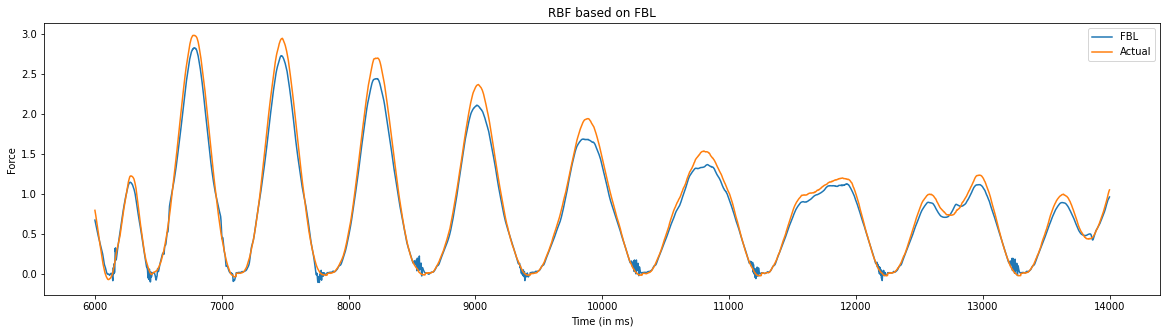

In [17]:
plt.figure(figsize=(20,5))
plt.plot(list(range(6000,14000)),y1[6000:14000], label = 'FBL')
plt.plot(list(range(6000,14000)),y_test[6000:14000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

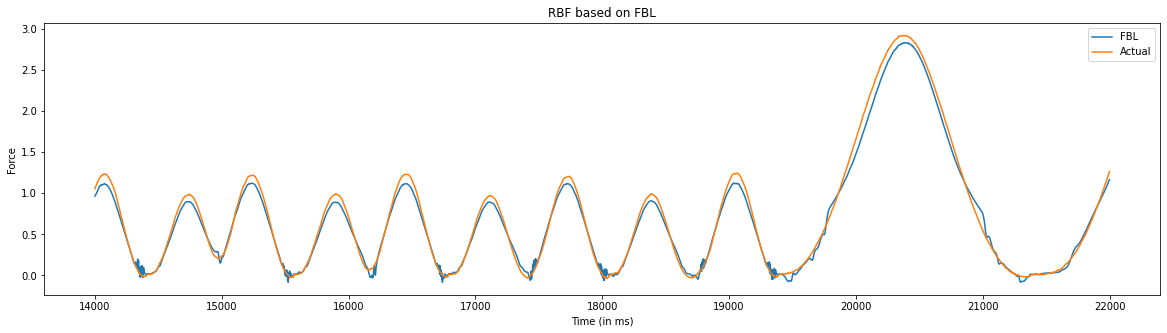

In [18]:
plt.figure(figsize=(20,5))
plt.plot(list(range(14000,22000)),y1[14000:22000], label = 'FBL')
plt.plot(list(range(14000,22000)),y_test[14000:22000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

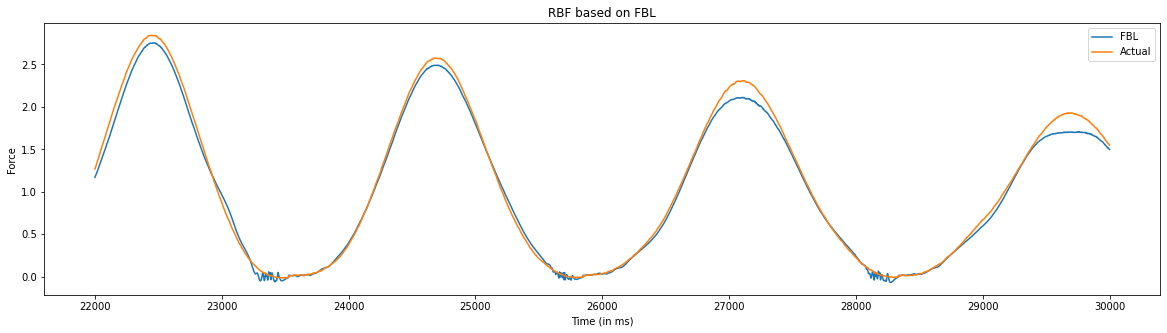

In [19]:
plt.figure(figsize=(20,5))
plt.plot(list(range(22000,30000)),y1[22000:30000], label = 'FBL')
plt.plot(list(range(22000,30000)),y_test[22000:30000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

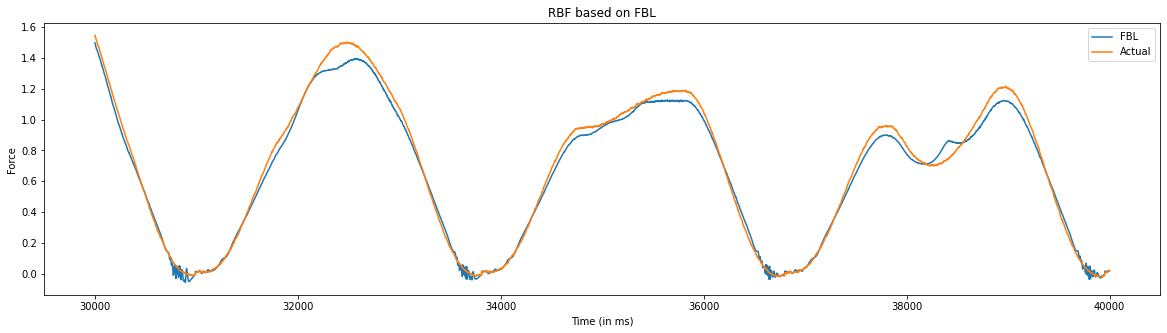

In [20]:
plt.figure(figsize=(20,5))
plt.plot(list(range(30000,40000)),y1[30000:40000], label = 'FBL')
plt.plot(list(range(30000,40000)),y_test[30000:40000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

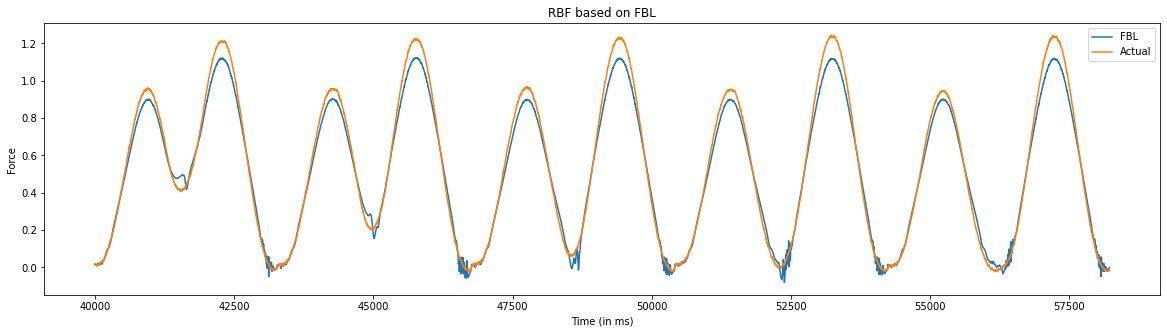

In [21]:
plt.figure(figsize=(20,5))
plt.plot(list(range(40000,58223)),y1[40000:58223], label = 'FBL')
plt.plot(list(range(40000,58223)),y_test[40000:58223], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

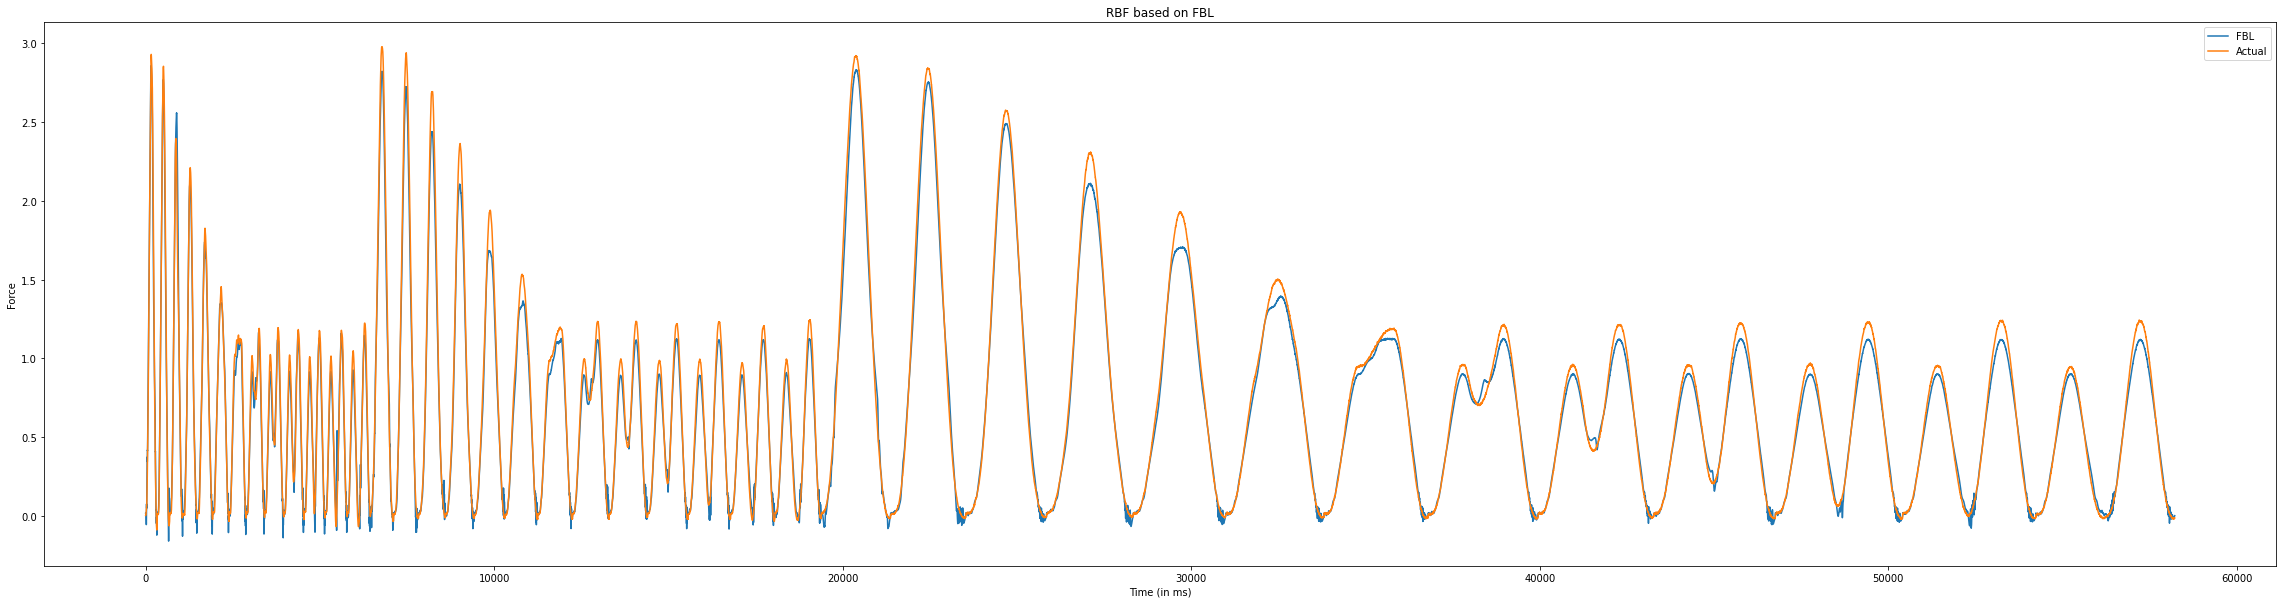

In [22]:
plt.figure(figsize=(40,10))
plt.plot(list(range(58223)),y1[:58223], label = 'FBL')
plt.plot(list(range(58223)),y_test[:58223], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.savefig('Perceptual_Sampling.jpg')
plt.show()

In [23]:
error5 = []
for i in range(len(y_test)):
    error5.append(abs(y1[i]-y_test[i]))
print('Minimum Error =',min(error5))
print('Maximum Error =',max(error5))
error6 = sorted(error5)
print('Median Value of Error =',error6[len(error5)//2])

Minimum Error = 8.245230900504052e-07
Maximum Error = 0.5236583835355937
Median Value of Error = 0.040662218812806544


# Catboost on present data

In [24]:
from catboost import CatBoostRegressor
x = np.array(z.iloc[:,2:])
y = np.array(f.iloc[:,2])

cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x,y)
t2 = datetime.now()

Learning rate set to 0.049612
0:	learn: 1.1048289	total: 71.4ms	remaining: 1m 11s
1:	learn: 1.0582106	total: 80.3ms	remaining: 40.1s
2:	learn: 1.0147850	total: 93.8ms	remaining: 31.2s
3:	learn: 0.9730430	total: 99.4ms	remaining: 24.8s
4:	learn: 0.9338415	total: 102ms	remaining: 20.3s
5:	learn: 0.8935015	total: 113ms	remaining: 18.7s
6:	learn: 0.8562926	total: 117ms	remaining: 16.6s
7:	learn: 0.8212147	total: 119ms	remaining: 14.8s
8:	learn: 0.7877049	total: 130ms	remaining: 14.3s
9:	learn: 0.7537199	total: 140ms	remaining: 13.9s
10:	learn: 0.7218723	total: 142ms	remaining: 12.8s
11:	learn: 0.6931567	total: 144ms	remaining: 11.8s
12:	learn: 0.6654304	total: 148ms	remaining: 11.2s
13:	learn: 0.6398770	total: 185ms	remaining: 13.1s
14:	learn: 0.6127032	total: 187ms	remaining: 12.3s
15:	learn: 0.5869496	total: 193ms	remaining: 11.8s
16:	learn: 0.5629690	total: 195ms	remaining: 11.3s
17:	learn: 0.5406416	total: 197ms	remaining: 10.7s
18:	learn: 0.5181252	total: 238ms	remaining: 12.3s
19:	le

In [25]:
print('Time taken by Cat Boosting:',t2-t1)

y_pred = cat.predict(x_test)
print('Root mean square error of Cat Boost Model: ',sqrt(mean_squared_error(y_test,y_pred)))

Time taken by Cat Boosting: 0:00:09.461837
Root mean square error of Cat Boost Model:  0.05168079430562508


/DATA/kumar156/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  after removing the cwd from sys.path.


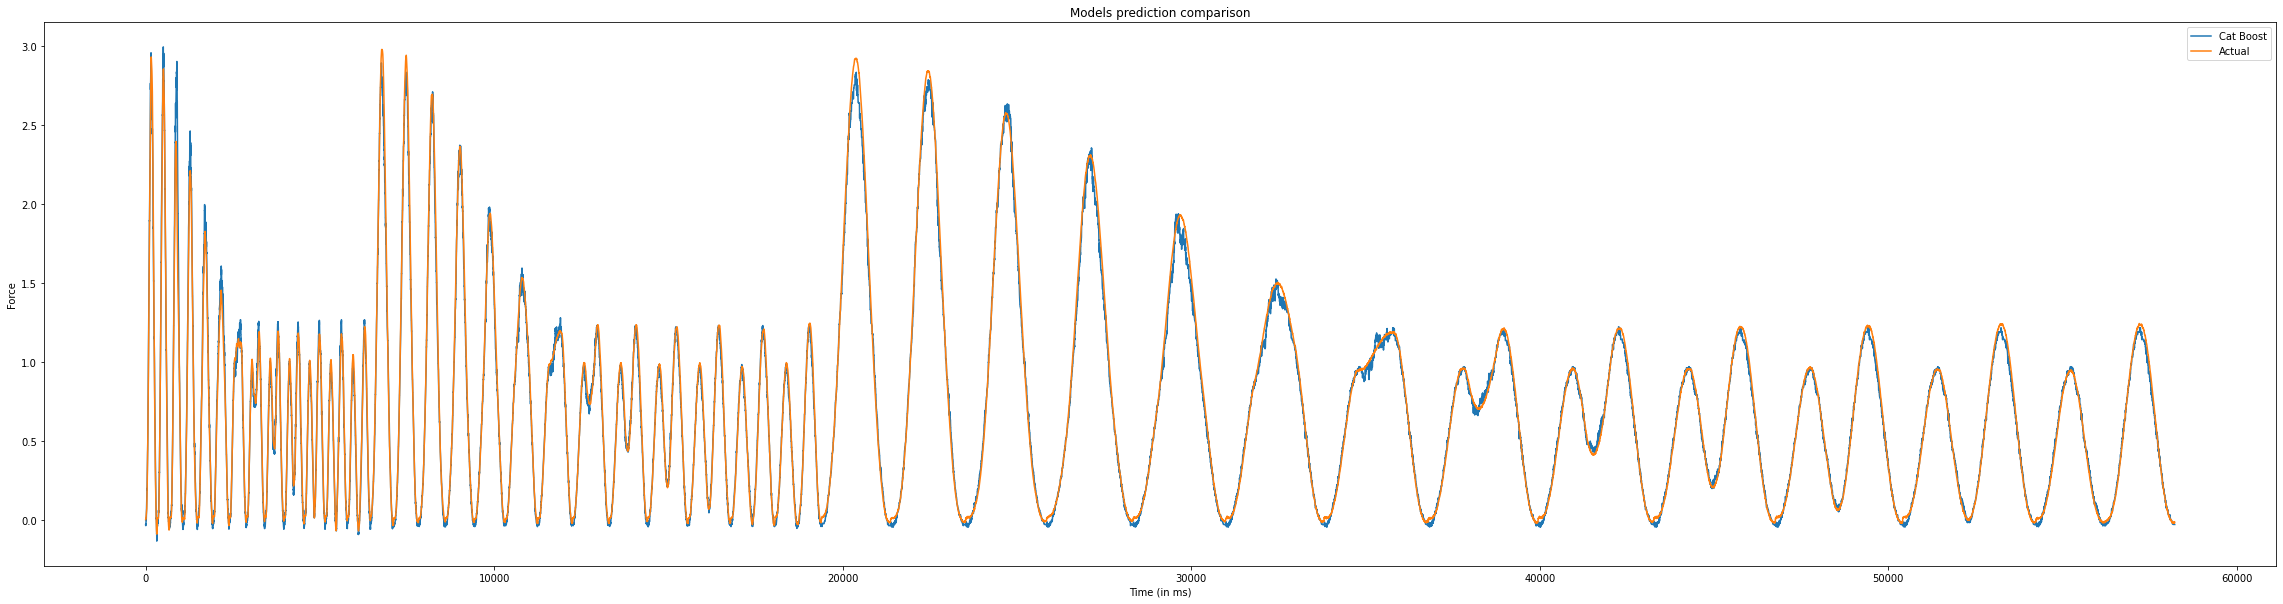

In [26]:
plt.figure(figsize=(40,10))
plt.plot(list(range(58223)),y_pred[:58223], label = 'Cat Boost')
plt.plot(list(range(58223)),y_test[:58223], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('Models prediction comparison')
plt.savefig('catboost_using_perceptual_data.jpg')
plt.show()

# Random Forest on Perceptual data

Time taken by Random Forest 0:00:01.705184
Root Mean Squared error of Random Forest 0.057113256664986824
Minimum Error = 0.0
Maximum Error = 0.6416809999999993
Median Value of Error = 0.024502000000000024


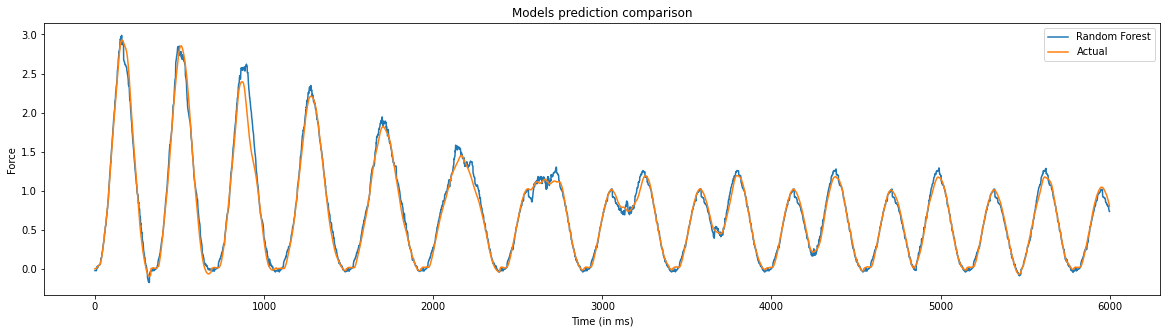

In [28]:
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
if __name__ == '__main__':
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x,y)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test[i]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()

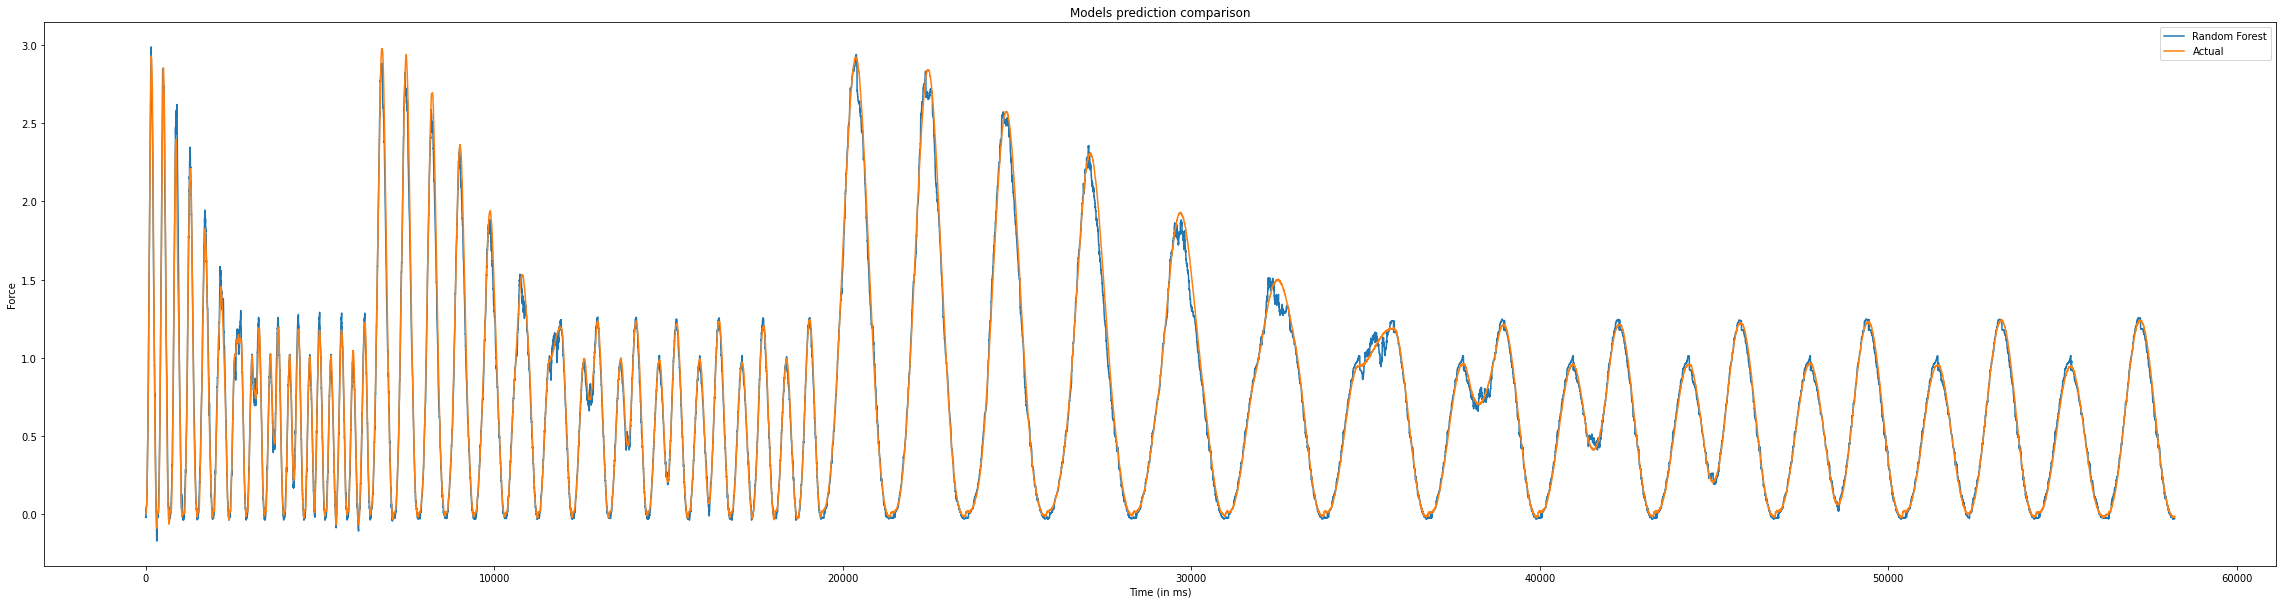

In [29]:
if 1 == 1:
    plt.figure(figsize=(40,10))
    plt.plot(list(range(58223)),y1[:58223], label = 'Random Forest')
    plt.plot(list(range(58223)),y_test[:58223], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.savefig('RF_Perceptual_data.jpg')
    plt.show()

# SVR



Time taken by SVR Model:  0:00:00.594253
Root mean square error of SVR Model:  0.059457742814479415
Minimum Error = 4.3475126498826455e-07
Maximum Error = 0.5881543361644446
Median Value of Error = 0.025258745771430224


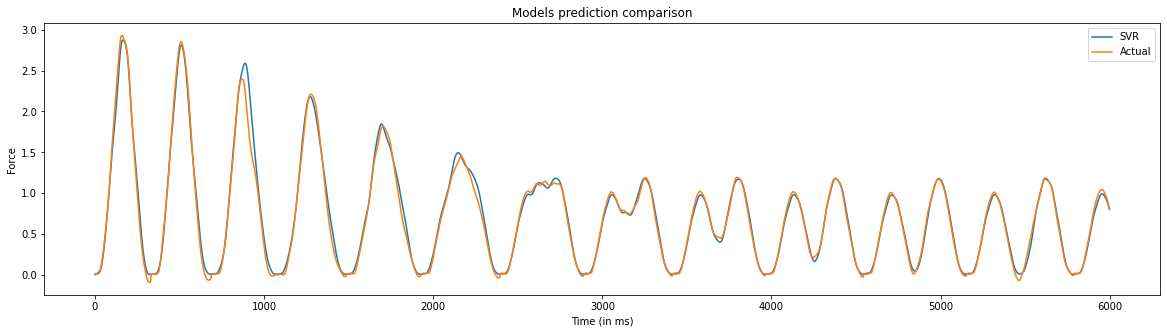

In [30]:
# SVR MODEL
from sklearn.svm import SVR
if __name__ == '__main__':
    t1 = datetime.now()
    clf = SVR()
    clf.fit(x,y)
    t2 = datetime.now()

    print('\n\nTime taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test[i]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()

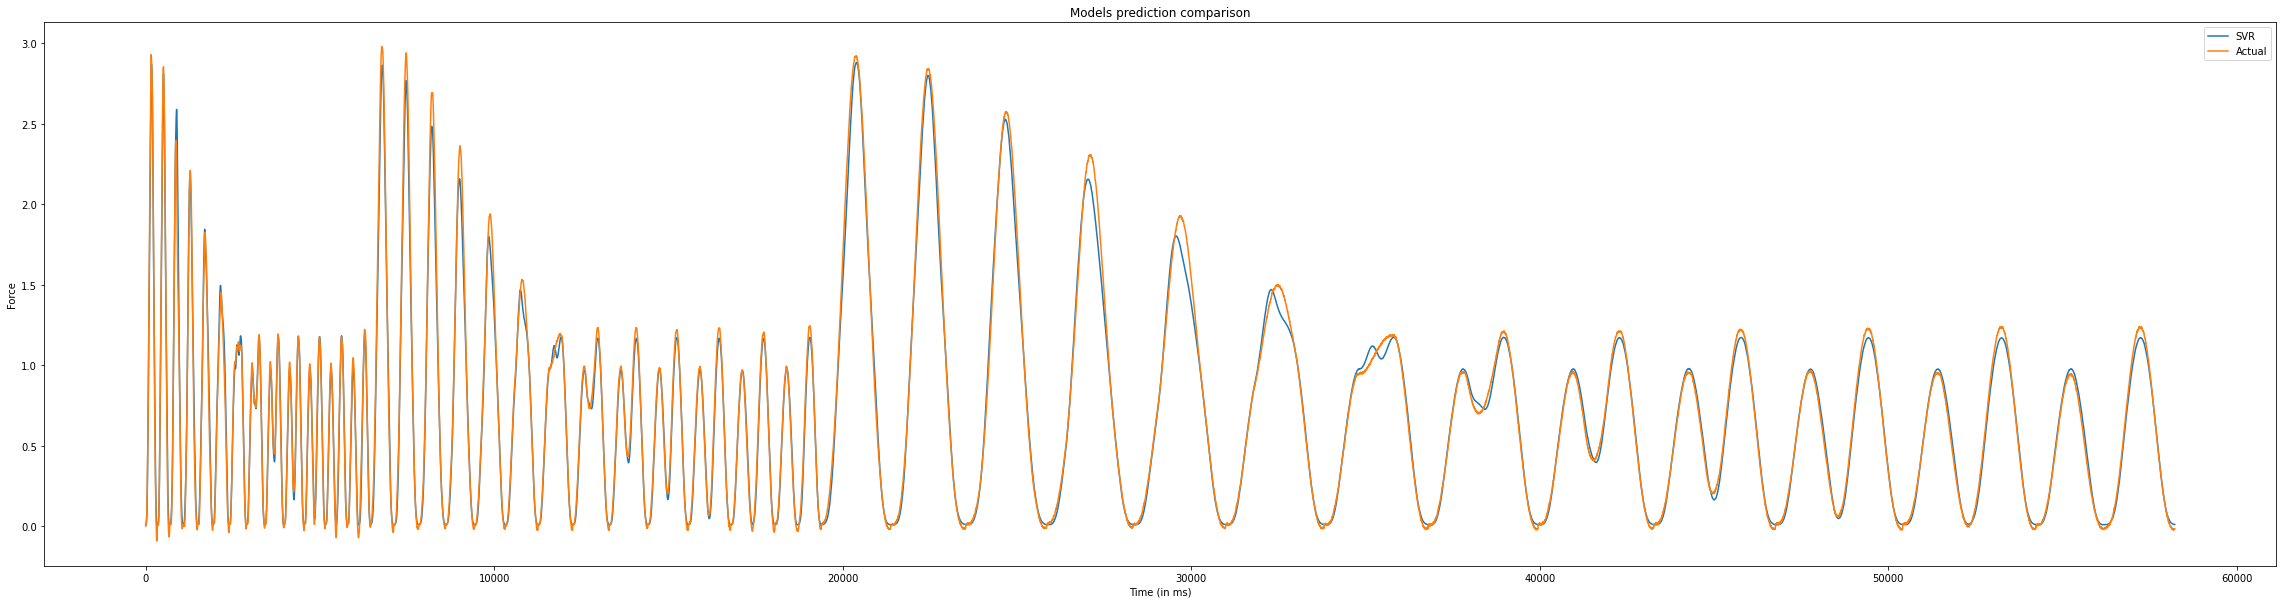

In [31]:
if 1 == 1:
    plt.figure(figsize=(40,10))
    plt.plot(list(range(58223)),y4[:58223], label = 'SVR')
    plt.plot(list(range(58223)),y_test[:58223], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.savefig('SVR_Perceptual_data.jpg')
    plt.show()